# Planet: Understanding the Amazon from Space

In [1]:
from fastai.vision import *
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Exploring the data

In [2]:
path = Config.data_path()/'planet'
path

PosixPath('/home/ncondo/.fastai/data/planet')

In [3]:
print('# File sizes')
p = str(path)
for f in os.listdir(p):
    if not os.path.isdir(p+'/'+ f):
        print (f.ljust(30) + str(round(os.path.getsize(p+'/'+ f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize(p +'/'+f + '/'+x)/1000000 for x in os.listdir(p+'/'+f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + '({} files)'.format(len(sizes)))

# File sizes
test-jpg                      637.8MB(40669 files)
train_v2.csv                  1.43MB
train-jpg                     634.68MB(40479 files)
sample_submission_v2.csv      2.91MB
test-jpg-additional           321.08MB(20522 files)


The labels are in the csv entitled ```train_v2.csv```. We can take a look at each image to see that each 'image_name' can have multiple 'tags'.

In [4]:
labels_df = pd.read_csv(path/'train_v2.csv')
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


One-hot encode the labels and view the label distributions

In [5]:
# Get each unique label
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [6]:
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


Now we can create a histogram of label instances

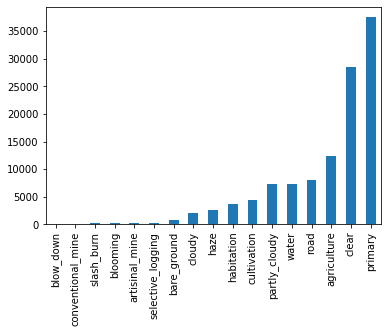

In [7]:
labels_df[label_list].sum().sort_values().plot.bar()

And look at a cooccurence matrix of the labels

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


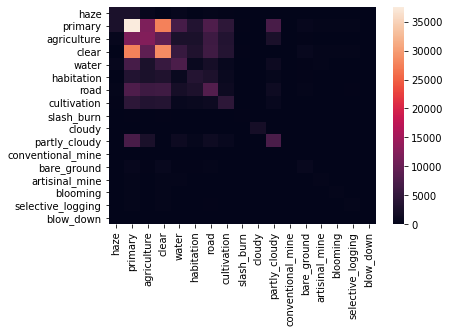

In [13]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

make_cooccurence_matrix(label_list)

Each image should have exactly one weather label

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


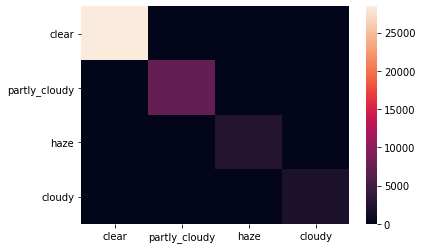

In [14]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

The land labels overlap

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


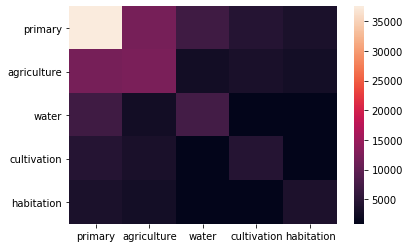

In [15]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rare labels have very little overlap

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


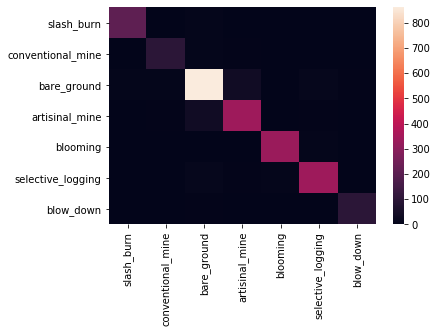

In [29]:
rare_labels = [label for label in label_list if labels_df[label].sum() < 2000]
make_cooccurence_matrix(rare_labels)

We can easily inspect the images by using the fastai library to create a ```DataBunch```.

In [32]:
data = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        .split_none()
        .label_from_df(label_delim=' ')).databunch()

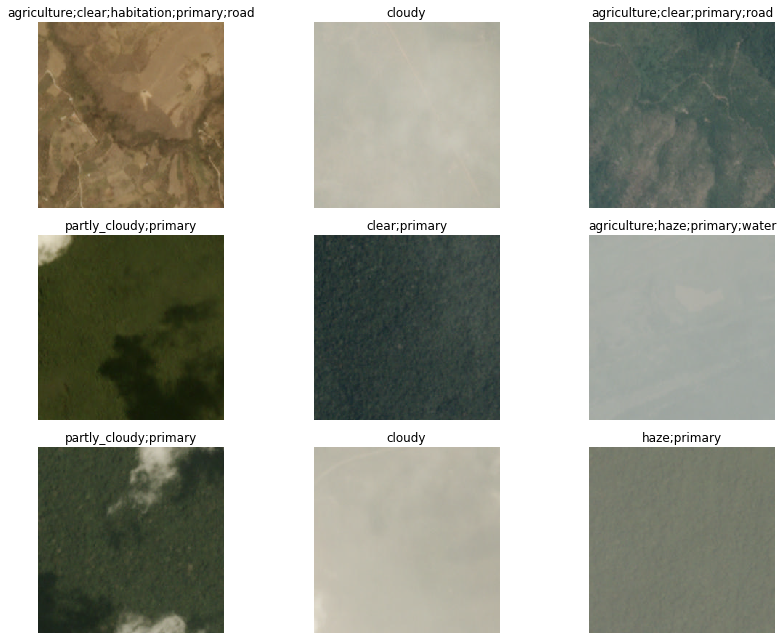

In [33]:
data.show_batch(rows=3, figsize=(12,9))

## References
1. [Getting started with the data - now with docs!](https://www.kaggle.com/robinkraft/getting-started-with-the-data-now-with-docs)
2. [fast.ai lesson3-planet.ipynb](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb)